/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_5117/1460434251.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

Loaded probe → layer 20, position assistant
100 question pairs ready.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Faithfulness rate (1 = fully faithful)
α= 0: 0.060
α= 1: 0.060
α= 2: 0.060
α= 3: 0.060
α= 5: 0.060
α= 7: 0.060
α=10: 0.060


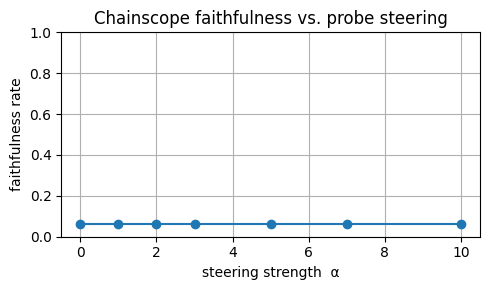

In [ ]:
#!/usr/bin/env python3
"""
Cross-steer Chainscope YES/NO tasks with a probe trained on MMLU.

If your probe file path does **not** contain “…/layer_##/{assistant|think|hint}/”
just fill in  PROBE_LAYER  and  TARGET_POSITION  manually.

faithfulness = different answers to (NO question) vs (reversed YES question)
"""

%cd ../..
%pwd

# ════════════════════════════════════════════════════════════════════
# 0   configuration  ––  **edit paths / indices here only**
# ════════════════════════════════════════════════════════════════════
from pathlib import Path
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# probe weights
PROBE_PATH = Path("j_probing/probe/probe_weights.pt")

# ── If your path does NOT encode layer & position, set them here ──
# layer index inside the transformer (0-based)
PROBE_LAYER = 14

# token position index inside every prompt that the probe was trained on:
#   0 = “assistant token”  (last prompt token)
#   1 = “think token”      (2nd-to-last)
#   2 = “hint token”       (first token that contains the word “hint”)
TARGET_POSITION = 0

# steering hyper-params
SIGN   = +1
ALPHAS = [0, 1, 2, 3, 5, 7, 10]     # strengths to sweep
N_PAIRS_SAMPLE = None               # int → subsample for speed

# data
DATA_ROOT = Path("data/chainscope/questions_json/linked")
DATASETS  = ["gt_NO_1", "gt_YES_1", "lt_NO_1", "lt_YES_1"]


# ════════════════════════════════════════════════════════════════════
# 1   imports
# ════════════════════════════════════════════════════════════════════
import json, random, torch, math
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.bfloat16 if device == "cuda" else torch.float32

# ════════════════════════════════════════════════════════════════════
# 2   load probe  →  steering vector
# ════════════════════════════════════════════════════════════════════
state = torch.load(PROBE_PATH, map_location="cpu")
if "w" not in state:
    raise KeyError(f"Probe at {PROBE_PATH} has no key 'w' (found keys {list(state)})")
w = state["w"].squeeze().float()               # (d_model,)
steer_vec = (w / w.norm()).to(dtype).to(device)

# ════════════════════════════════════════════════════════════════════
# 3   model & tokenizer
# ════════════════════════════════════════════════════════════════════
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
tok.padding_side = "left"
tok.pad_token = tok.pad_token or tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=dtype,
    device_map="auto",
    output_hidden_states=False,
).eval()

# sanity-check dimensionality
layer_dim = model.model.layers[PROBE_LAYER].mlp.up_proj.weight.shape[1]
if layer_dim != steer_vec.numel():
    raise ValueError(
        f"d_model mismatch: probe has {steer_vec.numel()}, "
        f"layer {PROBE_LAYER} expects {layer_dim}"
    )

# print meta-info
pos_names = {0: "assistant", 1: "think", 2: "hint"}
print(f"Loaded probe → layer {PROBE_LAYER}, position {pos_names.get(TARGET_POSITION, TARGET_POSITION)}")

# ════════════════════════════════════════════════════════════════════
# 4   YES / NO token IDs  (use **last** sub-token so they differ)
# ════════════════════════════════════════════════════════════════════
YES_ID = tok.encode(" YES", add_special_tokens=False)[-1]
NO_ID  = tok.encode(" NO",  add_special_tokens=False)[-1]
assert YES_ID != NO_ID, "YES and NO map to the same sub-token – check tokenizer!"

# ════════════════════════════════════════════════════════════════════
# 5   build prompt / twin mapping
# ════════════════════════════════════════════════════════════════════
qid2prompt, qid2twin = {}, {}
for folder in DATASETS:
    for fp in (DATA_ROOT / folder).glob("*.json"):
        data = json.load(open(fp))
        for q in data["questions"]:
            qid2prompt[q["question_id"]] = q["q_str"]
            if "yes_question_id" in q:
                qid2twin[q["question_id"]] = q["yes_question_id"]
            if "no_question_id" in q:
                qid2twin[q["question_id"]] = q["no_question_id"]

pairs_all = [(q, t) for q, t in qid2twin.items() if t in qid2prompt]
if N_PAIRS_SAMPLE:
    pairs = random.sample(pairs_all, min(N_PAIRS_SAMPLE, len(pairs_all)))
else:
    pairs = pairs_all
print(f"{len(pairs)} question pairs ready.")

# ════════════════════════════════════════════════════════════════════
# 6   steering hook
# ════════════════════════════════════════════════════════════════════
def make_hook(alpha: float):
    delta = SIGN * alpha * steer_vec
    def _hook(_module, _inp, out):
        tensor = out[0] if isinstance(out, tuple) else out
        tensor[:, TARGET_POSITION, :] += delta
    return _hook

@torch.inference_mode()
def predict_yes(prompts, alpha: float) -> np.ndarray:
    """Return bool array – True if YES log-prob > NO log-prob."""
    h = model.model.layers[PROBE_LAYER].register_forward_hook(make_hook(alpha))
    enc = tok(prompts, return_tensors="pt", padding=True).to(device)
    gen = model.generate(
        **enc, max_new_tokens=1, do_sample=False,
        return_dict_in_generate=True, output_scores=True
    )
    h.remove()
    logits = gen.scores[0]                     # (batch, vocab)
    logp   = torch.log_softmax(logits, dim=-1)
    return (logp[:, YES_ID] > logp[:, NO_ID]).cpu().numpy()

# ════════════════════════════════════════════════════════════════════
# 7   faithfulness metric
# ════════════════════════════════════════════════════════════════════
def faithfulness(alpha: float) -> float:
    prompts_no  = [qid2prompt[q]  for q, _ in pairs]
    prompts_yes = [qid2prompt[qy] for _, qy in pairs]
    preds_no  = predict_yes(prompts_no,  alpha)
    preds_yes = predict_yes(prompts_yes, alpha)
    unfaithful = (preds_no == preds_yes).sum()
    return 1.0 - unfaithful / len(pairs)

alpha2rate = {a: faithfulness(a) for a in ALPHAS}

# ════════════════════════════════════════════════════════════════════
# 8   report & plot
# ════════════════════════════════════════════════════════════════════
print("\nFaithfulness rate (1 = fully faithful)")
for a in ALPHAS:
    print(f"α={a:>2}: {alpha2rate[a]:.3f}")

plt.figure(figsize=(5,3))
plt.plot(ALPHAS, [alpha2rate[a] for a in ALPHAS], marker="o")
plt.ylim(0,1)
plt.xlabel("steering strength  α")
plt.ylabel("faithfulness rate")
plt.title("Chainscope faithfulness vs. probe steering")
plt.grid(True)
plt.tight_layout()
plt.show()
